# Hierarchical Clustering Example

Using the IMDB data, construct a feature matrix, apply dimensionality reduction to this matrix as needed via SVD, and apply `AgglomerativeClustering` to the data to extract clusters.

In [1]:
%matplotlib inline

In [31]:
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter

from scipy.sparse import lil_matrix

from sklearn.neighbors import DistanceMetric

from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances

In [3]:
# Let's restrict ourselves just to US titles
relevant_title_df = pd.read_csv("../data/us_relevant_titles.csv")

# And create a set of just these titles, so we can filter them
relevant_title_set = set(relevant_title_df["title"])

In [4]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_list = [] # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to American movies
        if this_movie["title_name"] not in relevant_title_set:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_list.append({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [5]:
print("Known Actors:", len(known_actors))

Known Actors: 161996


## Generate Same DataFrame using Sparse Matrics

The above will break if you have too much data. We can get around that partially with sparse matrices, where we only store the non-zero elements of the feature matrix and their indices.

In [6]:
# With sparse matrix, initialize to size of Movies x Actors of 0s
matrix_sparse = lil_matrix((len(movie_actor_list), len(known_actors)), dtype=bool)

# Update the matrix, movie by movie, setting non-zero values for the appropriate actors
for row,movie in enumerate(movie_actor_list):   
    for actor_id in movie["actors"]:
        this_index = actor_id_to_index_map[actor_id]
        matrix_sparse[row,this_index] = 1

In [7]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[m["movie"] for m in movie_actor_list],
    columns=[index_to_actor_ids[i] for i in range(len(known_actors))]
)
df

,nm0001379,nm0000953,nm0864851,nm0933983,nm0329491,nm0000123,nm0000221,nm0307255,nm0635649,nm0033458,...,nm10823679,nm1290838,nm5580678,nm8370368,nm0578248,nm2952127,nm3611859,nm9445072,nm8594703,nm8680851
The Other Side of the Wind,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Naked Monster,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grizzly II: Revenge,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chief Zabu,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Life Without Sara Amat,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
The Rehearsal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
Safeguard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Coven,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
top_k_actors = 1000

In [9]:
# Extract the most frequent actors, so we can deal with a reasonable dataset size
actor_df = df.sum(axis=0)
top_actors = set(actor_df.sort_values().tail(top_k_actors).index)

In [10]:
# Restrict the data frame to just the movies containing
#. the top k actors
reduced_df = df[top_actors] # restrict to just these top actors

# throw away movies that don't have any of these actors
reduced_df = reduced_df.loc[reduced_df.sum(axis=1) > 0] 

reduced_df

,nm4446467,nm0005085,nm0998846,nm0019382,nm0705356,nm0746162,nm0000144,nm1045685,nm3452531,nm0251986,...,nm0000168,nm0000729,nm0000630,nm0792116,nm0000741,nm0000498,nm0001709,nm0893257,nm0176869,nm0000134
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apply SVD to Feature Matrix

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
from sklearn.decomposition import TruncatedSVD 

In [12]:
matrix_dense = reduced_df.to_numpy()
reduced_df

,nm4446467,nm0005085,nm0998846,nm0019382,nm0705356,nm0746162,nm0000144,nm1045685,nm3452531,nm0251986,...,nm0000168,nm0000729,nm0000630,nm0792116,nm0000741,nm0000498,nm0001709,nm0893257,nm0176869,nm0000134
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
svd = TruncatedSVD(n_components=2)

In [14]:
svd.fit(matrix_dense)

TruncatedSVD()

In [15]:
matrix_reduced = svd.transform(matrix_dense)

In [16]:
np.mean(matrix_reduced, axis=0)

array([0.01234145, 0.00850627])

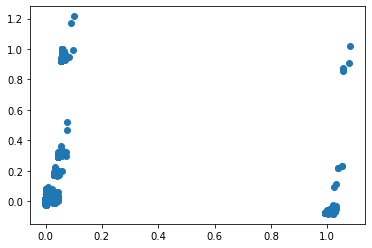

In [17]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1])

## Apply Clustering

We'll use AgglomerativeClustering from Sklearn to cluster this data.

In [45]:
from sklearn.cluster import AgglomerativeClustering

k = 4

model = AgglomerativeClustering(n_clusters=k)

In [46]:
model.fit(matrix_reduced)

AgglomerativeClustering(n_clusters=4)

In [47]:
reduced_df["cluster"] = model.labels_

In [48]:
reduced_df[["cluster"]]

,cluster
Grizzly II: Revenge,3
Crime and Punishment,3
For the Cause,3
Gang,3
In the Mood for Love,3
...,...
Fox Hunting,3
Mountain Quest,3
Enemy Lines,3
Manoharam,3


In [49]:
reduced_df["cluster"].value_counts()

3    18069
0      195
1      173
2       96
Name: cluster, dtype: int64

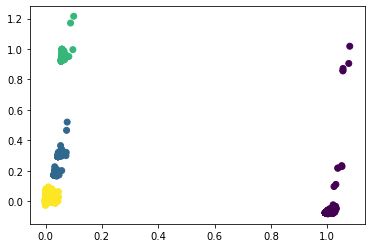

In [50]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1], c=reduced_df["cluster"])

In [52]:
for cluster,cluster_group in reduced_df.groupby("cluster"):
    print("Cluster:", cluster)
    
    sample_size = min(cluster_group.shape[0], 100)
    
    genre_counter = {}
    actor_counter = {}
    print("\t", "Movie Sample:")
    
    print_limit = 10
    for m in cluster_group.sample(n=sample_size).itertuples():
        if print_limit > 0:
            print("\t\t", m[0])
        print_limit -= 1
        
        this_movie_match = [movie for movie in movie_actor_list if movie["movie"] == m[0]]
        for movie in this_movie_match:
            for g in movie["genres"]:
                genre_counter[g] = genre_counter.get(g, 0) + 1
            for g in movie["actors"]:
                actor_counter[g] = actor_counter.get(g, 0) + 1
    
    print("\t", "Genres:")
    for g in sorted(genre_counter, key=genre_counter.get, reverse=True)[:10]:
        print("\t\t", g, genre_counter[g])
    print("\t", "Actors:")
    for a in sorted(actor_counter, key=actor_counter.get, reverse=True)[:10]:
        print("\t\t", actor_id_to_name_map[a], actor_counter[a])
    


Cluster: 0
	 Movie Sample:
		 Hunt to Kill
		 Welcome Home
		 Ape vs. Monster
		 Graves End
		 Scavenger Killers
		 Girl Games
		 Rusty Tulloch
		 Deadly Sanctuary
		 The Long Ride Home
		 The Night Never Sleeps
	 Genres:
		 Drama 76
		 Thriller 40
		 Action 33
		 Horror 29
		 Comedy 21
		 Crime 19
		 Mystery 12
		 Romance 11
		 Sci-Fi 8
		 Adventure 8
	 Actors:
		 Eric Roberts 100
		 Michael Madsen 3
		 Tom Sizemore 3
		 Gary Daniels 2
		 Gore Abrams 2
		 Armand Assante 2
		 Danny Trejo 2
		 Daniel K. Daniel 2
		 Jsu Garcia 2
		 Steve Austin 1
Cluster: 1
	 Movie Sample:
		 Joe's War
		 A Broken Life
		 Atomica
		 Beatdown
		 Bad Ass
		 The Slider
		 Jake's Corner
		 Fury of the Fist and the Golden Fleece
		 USS Indianapolis: Men of Courage
		 Bad Ass
	 Genres:
		 Drama 70
		 Action 42
		 Thriller 41
		 Crime 32
		 Comedy 25
		 Horror 22
		 Sci-Fi 7
		 Fantasy 7
		 Mystery 7
		 Adventure 7
	 Actors:
		 Tom Sizemore 55
		 Danny Trejo 49
		 Armand Assante 2
		 Ving Rhames 2
		 Frank Stal

## Clustering in Unreduced Space

Above, we cluster after using SVD to reduce the feature space into a more managable size. We can also do this clustering in the full space and see how it compares.

In [53]:
model = AgglomerativeClustering(n_clusters=k)
model.fit(matrix_dense)

AgglomerativeClustering(n_clusters=4)

In [54]:
reduced_df["cluster_full"] = model.labels_

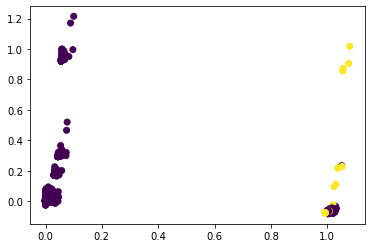

In [55]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1], c=reduced_df["cluster_full"])

In [56]:
for cluster,cluster_group in reduced_df.groupby("cluster_full"):
    print("Cluster:", cluster)
    
    sample_size = min(cluster_group.shape[0], 100)
    
    genre_counter = {}
    actor_counter = {}
    print("\t", "Movie Sample:")
    
    print_limit = 10
    for m in cluster_group.sample(n=sample_size).itertuples():
        if print_limit > 0:
            print("\t\t", m[0])
        print_limit -= 1
        
        this_movie_match = [movie for movie in movie_actor_list if movie["movie"] == m[0]]
        for movie in this_movie_match:
            for g in movie["genres"]:
                genre_counter[g] = genre_counter.get(g, 0) + 1
            for g in movie["actors"]:
                actor_counter[g] = actor_counter.get(g, 0) + 1
    
    print("\t", "Genres:")
    for g in sorted(genre_counter, key=genre_counter.get, reverse=True)[:10]:
        print("\t\t", g, genre_counter[g])
    print("\t", "Actors:")
    for a in sorted(actor_counter, key=actor_counter.get, reverse=True)[:10]:
        print("\t\t", actor_id_to_name_map[a], actor_counter[a])
    



Cluster: 0
	 Movie Sample:
		 Pocket Listing
		 Frontier Justice
		 Purgatory
		 The Smell of Success
		 Transporter 2
		 Bungee Jumping of Their Own
		 Jerusalem Countdown
		 Trick the Movie: Last Stage
		 Kavacha
		 My Dear Elephant
	 Genres:
		 Drama 83
		 Comedy 36
		 Crime 28
		 Thriller 26
		 Action 23
		 Romance 21
		 Horror 15
		 Mystery 12
		 Fantasy 9
		 Adventure 8
	 Actors:
		 Sergey A. 2
		 Evgeniy Mishukhin 2
		 Billy Bob Thornton 2
		 Lee Byung-hun 2
		 Kazuki Kitamura 2
		 Michael Paré 2
		 Peter Sarsgaard 2
		 Abhishek Bachchan 2
		 Akira Emoto 2
		 Tommy Flanagan 2
Cluster: 1
	 Movie Sample:
		 The Stan Stylez Intergender Bonanza 4
		 H20: You Shouldn't Have Done That
		 H20: Bad Luck
		 H20: Blood Money
		 H20: Hustlepalooza
		 H20: Hustlemania
		 H20: Brutality
		 The Stan Stylez Intergender Bonanza 6
		 H20: Misery Business
		 H20: It Was All a Dream
	 Genres:
		 Sport 59
		 Biography 1
		 Action 1
		 Documentary 1
	 Actors:
		 Jeff Cannonball 50
		 Mark Angelosett

## Hierarchy of Clusters

Because we're using Agglomerative Clustering, we can extract the relationships among clusters. We'll use an example from sklearn's website to visualize this: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [57]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [60]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(matrix_reduced)


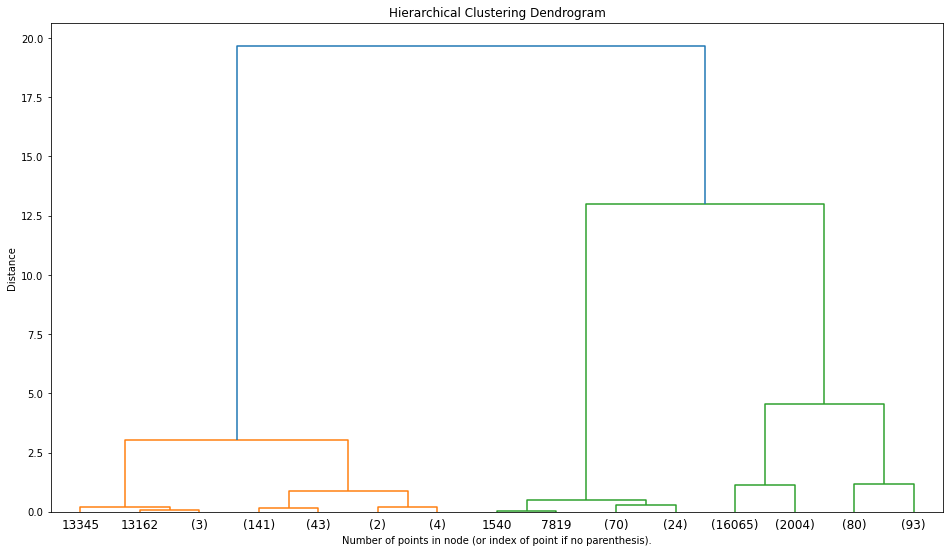

In [66]:
fig = plt.figure(figsize=(16,9))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.ylabel("Distance")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()